# 线性回归——从零开始

尽管强大的深度学习框架可以减少大量重复性工作，但若过于依赖它提供的便利，你就会很难深入理解深度学习是如何工作的。因此，我们的第一个教程是如何只利用ndarray和autograd来实现一个线性回归的训练。

## 线性回归

给定一个数据点集合`X`和对应的目标值`y`，线性模型的目标就是找到一条使用向量`w`和位移`b`描述的线，来尽可能地近似每个样本`X[i]`和`y[i]`。用数学符号来表示就是：

$$\boldsymbol{\hat{y}} = X \boldsymbol{w} + b$$

并最小化所有数据点上的平方误差

$$\sum_{i=1}^n (\hat{y}_i-y_i)^2.$$

你可能会对我们把古老的线性回归作为深度学习的一个样例表示奇怪。实际上线性模型是最简单、但也是最有用的神经网络。一个神经网络就是一个由节点（神经元）和有向边组成的集合。我们一般把一些节点组成层，每一层先从下面一层的节点获取输入，然后输出给上面的层使用。要计算一个节点值，我们需要将输入节点值做加权和（权数值即 `w`），然后再加上一个**激活函数（activation function）**。对于线性回归而言，它是一个两层神经网络，其中第一层是（下图橙色点）输入，每个节点对应输入数据点的一个维度，第二层是单输出节点（下图绿色点），它使用身份函数（$f(x)=x$）作为激活函数。

![](../img/onelayer.png)

## 创建数据集

这里我们使用一个数据集来尽量简单地解释清楚，真实的模型是什么样的。具体来说，我们使用如下方法来生成数据；随机数值 `X[i]`，其相应的标注为 `y[i]`：

`y[i] = 2 * X[i][0] - 3.4 * X[i][1] + 4.2 + noise`

使用数学符号表示：

$$y = X \cdot w + b + \eta, \quad \text{for } \eta \sim \mathcal{N}(0,\sigma^2)$$

这里噪音服从均值0和标准差为0.01的正态分布。

In [1]:
from mxnet import ndarray as nd
from mxnet import autograd

num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

X = nd.random_normal(shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(shape=y.shape)
print(X)
print(y)


[[ 2.21220636  0.7740038 ]
 [ 1.04344046  1.18392551]
 [ 1.89171135 -1.23474145]
 ..., 
 [ 0.42236066  0.36030969]
 [ 0.1177411  -1.06993568]
 [-0.03442945 -0.11181278]]
<NDArray 1000x2 @cpu(0)>

[  6.00058699e+00   2.26762176e+00   1.21922855e+01   2.19331312e+00
   1.16779327e+01   9.45502162e-01   4.81350183e+00   3.31076193e+00
   3.67973149e-01   4.37350655e+00   5.92764187e+00   4.89123249e+00
   1.14703417e-01   4.89729834e+00   6.63699627e+00   3.04140449e+00
   3.68024325e+00  -1.09772599e+00   4.24649858e+00   1.76260531e+00
   3.12361550e+00   7.26333475e+00   2.02706981e+00   9.56701851e+00
   7.03674841e+00   9.26425552e+00   4.29679267e-03   3.05101156e+00
   9.62822914e+00   5.14393282e+00   2.61765623e+00   4.65436125e+00
   4.05559874e+00  -1.06317675e+00   1.42257905e+00  -1.48423821e-01
   4.72640228e+00   2.17679954e+00   8.60468769e+00   3.21637201e+00
   2.36237001e+00   4.25050449e+00   8.13547325e+00   5.16207981e+00
  -1.01195765e+00   1.29253113e+00   3.95248

注意到`X`的每一行是一个长度为2的向量，而`y`的每一行是一个长度为1的向量（标量）。

In [2]:
print(X[0], y[0])


[ 2.21220636  0.7740038 ]
<NDArray 2 @cpu(0)> 
[ 6.00058699]
<NDArray 1 @cpu(0)>


如果有兴趣，可以使用安装包中已包括的 Python 绘图包 `matplotlib`，生成第二个特征值 (`X[:, 1]`) 和目标值 `Y` 的散点图，更直观地观察两者间的关系。

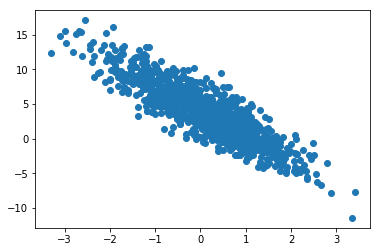

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(),y.asnumpy())
plt.show()

## 数据读取

当我们开始训练神经网络的时候，我们需要不断读取数据块。这里我们定义一个函数它每次返回`batch_size`个随机的样本和对应的目标。我们通过python的`yield`来构造一个迭代器。

In [4]:
import random
batch_size = 10
def data_iter():
    # 产生一个随机索引
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size,num_examples)])
        yield nd.take(X, j), nd.take(y, j)

下面代码读取第一个随机数据块

In [5]:
for data, label in data_iter():
    print(data, label)
    break


[[-0.9906556   0.1680257 ]
 [ 0.79784435  0.4279041 ]
 [-0.54206413  1.07188106]
 [-0.54291499  1.29740858]
 [ 0.12767315 -0.3437213 ]
 [-0.67570597 -1.05316365]
 [-0.69309121 -0.68236506]
 [-0.5013274  -1.67310596]
 [ 0.52217364 -0.96701854]
 [ 0.29560572 -1.21692061]]
<NDArray 10x2 @cpu(0)> 
[ 1.6602335   4.35635042 -0.53148514 -1.29311502  5.63614178  6.42942095
  5.12437916  8.87740326  8.52682495  8.94194221]
<NDArray 10 @cpu(0)>


## 初始化模型参数

下面我们随机初始化模型参数

In [6]:
w = nd.random_normal(shape=(num_inputs, 1))
b = nd.zeros((1,))
params = [w, b]

之后训练时我们需要对这些参数求导来更新它们的值，使损失尽量减小；因此我们需要创建它们的梯度。

In [7]:
for param in params:
    param.attach_grad()

## 定义模型

线性模型就是将输入和模型的权重（`w`）相乘，再加上偏移（`b`）：

In [8]:
def net(X):
#     print(X.shape)
#     print(w.shape)
#     print(nd.dot(X, w).shape)
    return nd.dot(X, w) + b

## 损失函数

我们使用常见的平方误差来衡量预测目标和真实目标之间的差距。

In [9]:
def square_loss(yhat, y):
    # 注意这里我们把y变形成yhat的形状来避免矩阵形状的自动转换
    return (yhat - y.reshape(yhat.shape)) ** 2

## 优化

虽然线性回归有显式解，但绝大部分模型并没有。所以我们这里通过随机梯度下降来求解。每一步，我们将模型参数沿着梯度的反方向走特定距离，这个距离一般叫**学习率（learning rate）** `lr`。（我们会之后一直使用这个函数，我们将其保存在[utils.py](../utils.py)。）

In [10]:
def SGD(params, lr):
    for param in params:
        print(param.grad)
        param[:] = param - lr * param.grad

## 训练

现在我们可以开始训练了。训练通常需要迭代数据数次，在这里使用`epochs`表示迭代总次数；一次迭代中，我们每次随机读取固定数个数据点，计算梯度并更新模型参数。

In [11]:
# 模型函数
def real_fn(X):
    return true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
# 绘制损失随训练次数降低的折线图，以及预测值和真实值的散点图
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '*g', label='Real')
    fg2.legend()
    plt.show()

In [12]:
epochs = 5
learning_rate = .001
niter = 0
losses = []
moving_loss = 0
smoothing_constant = .01

# 训练
for e in range(epochs):    
    total_loss = 0

    for data, label in data_iter():
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        total_loss += nd.sum(loss).asscalar()

        # 记录每读取一个数据点后，损失的移动平均值的变化；
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        print("Epoch %s, batch %s. Moving avg of loss: %s. Average loss: %f" % (e, niter, est_loss, total_loss/num_examples))
        


[[-42.62696838]
 [ 22.99453545]]
<NDArray 2x1 @cpu(0)>

[-83.30425262]
<NDArray 1 @cpu(0)>
Epoch 0, batch 1. Moving avg of loss: 25.0850715637. Average loss: 0.250851

[[-31.33101273]
 [ 69.46697998]]
<NDArray 2x1 @cpu(0)>

[-89.13998413]
<NDArray 1 @cpu(0)>
Epoch 0, batch 2. Moving avg of loss: 25.9474624749. Average loss: 0.518863

[[-62.18538666]
 [ 70.70920563]]
<NDArray 2x1 @cpu(0)>

[-78.05757141]
<NDArray 1 @cpu(0)>
Epoch 0, batch 3. Moving avg of loss: 26.7736844651. Average loss: 0.802877

[[-24.2500248 ]
 [ 15.96902561]]
<NDArray 2x1 @cpu(0)>

[-64.31415558]
<NDArray 1 @cpu(0)>
Epoch 0, batch 4. Moving avg of loss: 24.2633632186. Average loss: 0.971697

[[-23.09512711]
 [ -8.23345852]]
<NDArray 2x1 @cpu(0)>

[-66.72548676]
<NDArray 1 @cpu(0)>
Epoch 0, batch 5. Moving avg of loss: 22.5289004203. Average loss: 1.129325

[[-60.09641266]
 [ -7.57219839]]
<NDArray 2x1 @cpu(0)>

[-65.38860321]
<NDArray 1 @cpu(0)>
Epoch 0, batch 6. Moving avg of loss: 22.1600155335. Average loss: 1


[[-6.83863688]
 [-1.41900814]]
<NDArray 2x1 @cpu(0)>

[-10.70462799]
<NDArray 1 @cpu(0)>
Epoch 0, batch 89. Moving avg of loss: 6.10291329714. Average loss: 6.799293

[[-6.87938356]
 [ 7.3746562 ]]
<NDArray 2x1 @cpu(0)>

[-15.10361385]
<NDArray 1 @cpu(0)>
Epoch 0, batch 90. Moving avg of loss: 6.01337865071. Average loss: 6.807025

[[-13.50397682]
 [  0.94775277]]
<NDArray 2x1 @cpu(0)>

[-12.84844398]
<NDArray 1 @cpu(0)>
Epoch 0, batch 91. Moving avg of loss: 5.92573262158. Average loss: 6.814631

[[-7.20704651]
 [-4.41138411]]
<NDArray 2x1 @cpu(0)>

[-11.55259323]
<NDArray 1 @cpu(0)>
Epoch 0, batch 92. Moving avg of loss: 5.83604230407. Average loss: 6.819777

[[ -3.24943256]
 [ 10.44032001]]
<NDArray 2x1 @cpu(0)>

[-11.25367737]
<NDArray 1 @cpu(0)>
Epoch 0, batch 93. Moving avg of loss: 5.74900084061. Average loss: 6.825278

[[-1.09642029]
 [-5.33475637]]
<NDArray 2x1 @cpu(0)>

[-8.79905415]
<NDArray 1 @cpu(0)>
Epoch 0, batch 94. Moving avg of loss: 5.65928094794. Average loss: 6.82


[-2.18241739]
<NDArray 1 @cpu(0)>
Epoch 1, batch 175. Moving avg of loss: 1.95935558987. Average loss: 0.126441

[[-1.4398365 ]
 [ 1.03541827]]
<NDArray 2x1 @cpu(0)>

[-2.64254332]
<NDArray 1 @cpu(0)>
Epoch 1, batch 176. Moving avg of loss: 1.93605690659. Average loss: 0.126709

[[-1.63668394]
 [ 1.01974809]]
<NDArray 2x1 @cpu(0)>

[-1.60837173]
<NDArray 1 @cpu(0)>
Epoch 1, batch 177. Moving avg of loss: 1.91300600235. Average loss: 0.126911

[[-0.92052376]
 [-0.75205553]]
<NDArray 2x1 @cpu(0)>

[-2.25534248]
<NDArray 1 @cpu(0)>
Epoch 1, batch 178. Moving avg of loss: 1.89023993157. Average loss: 0.127079

[[-1.23351264]
 [ 1.58835554]]
<NDArray 2x1 @cpu(0)>

[-3.06284285]
<NDArray 1 @cpu(0)>
Epoch 1, batch 179. Moving avg of loss: 1.86793545004. Average loss: 0.127368

[[-1.60876119]
 [ 1.68806767]]
<NDArray 2x1 @cpu(0)>

[-1.77966046]
<NDArray 1 @cpu(0)>
Epoch 1, batch 180. Moving avg of loss: 1.84584653679. Average loss: 0.127577

[[-0.87671155]
 [-0.65311271]]
<NDArray 2x1 @cpu(0)


[[-0.04838927]
 [ 0.49004459]]
<NDArray 2x1 @cpu(0)>

[-0.86509085]
<NDArray 1 @cpu(0)>
Epoch 2, batch 226. Moving avg of loss: 1.0881107344. Average loss: 0.001674

[[-0.79412323]
 [ 1.07166982]]
<NDArray 2x1 @cpu(0)>

[-1.12745309]
<NDArray 1 @cpu(0)>
Epoch 2, batch 227. Moving avg of loss: 1.07605035515. Average loss: 0.001726

[[-0.29040596]
 [ 0.77581543]]
<NDArray 2x1 @cpu(0)>

[-0.94608021]
<NDArray 1 @cpu(0)>
Epoch 2, batch 228. Moving avg of loss: 1.06411615994. Average loss: 0.001759

[[-0.84846079]
 [ 0.64748681]]
<NDArray 2x1 @cpu(0)>

[-0.83037019]
<NDArray 1 @cpu(0)>
Epoch 2, batch 229. Moving avg of loss: 1.05232936566. Average loss: 0.001794

[[-0.76848781]
 [ 0.1073729 ]]
<NDArray 2x1 @cpu(0)>

[-1.06014371]
<NDArray 1 @cpu(0)>
Epoch 2, batch 230. Moving avg of loss: 1.04069233119. Average loss: 0.001833

[[-0.30307606]
 [-0.16597264]]
<NDArray 2x1 @cpu(0)>

[-0.88010085]
<NDArray 1 @cpu(0)>
Epoch 2, batch 231. Moving avg of loss: 1.02917874583. Average loss: 0.001856

Epoch 3, batch 314. Moving avg of loss: 0.421454326599. Average loss: 0.000035

[[-0.10192062]
 [ 0.17395131]]
<NDArray 2x1 @cpu(0)>

[-0.17926705]
<NDArray 1 @cpu(0)>
Epoch 3, batch 315. Moving avg of loss: 0.417057590014. Average loss: 0.000038

[[-0.0826266 ]
 [ 0.02016478]]
<NDArray 2x1 @cpu(0)>

[-0.21425015]
<NDArray 1 @cpu(0)>
Epoch 3, batch 316. Moving avg of loss: 0.412707954426. Average loss: 0.000041

[[-0.06566124]
 [-0.00932315]]
<NDArray 2x1 @cpu(0)>

[-0.07227898]
<NDArray 1 @cpu(0)>
Epoch 3, batch 317. Moving avg of loss: 0.408403720744. Average loss: 0.000041

[[-0.1614745 ]
 [ 0.14212467]]
<NDArray 2x1 @cpu(0)>

[-0.10791898]
<NDArray 1 @cpu(0)>
Epoch 3, batch 318. Moving avg of loss: 0.404148053125. Average loss: 0.000044

[[-0.25825328]
 [-0.06155666]]
<NDArray 2x1 @cpu(0)>

[-0.08206433]
<NDArray 1 @cpu(0)>
Epoch 3, batch 319. Moving avg of loss: 0.399937572593. Average loss: 0.000046

[[-0.04064113]
 [ 0.07834741]]
<NDArray 2x1 @cpu(0)>

[-0.11463869]
<NDArray 1 @

Epoch 4, batch 407. Moving avg of loss: 0.161231262536. Average loss: 0.000007

[[-0.03727381]
 [-0.00313147]]
<NDArray 2x1 @cpu(0)>

[ 0.02892798]
<NDArray 1 @cpu(0)>
Epoch 4, batch 408. Moving avg of loss: 0.159592434119. Average loss: 0.000008

[[ 0.01059139]
 [ 0.11302754]]
<NDArray 2x1 @cpu(0)>

[ 0.03003025]
<NDArray 1 @cpu(0)>
Epoch 4, batch 409. Moving avg of loss: 0.157970738317. Average loss: 0.000008

[[-0.04872931]
 [ 0.00780601]]
<NDArray 2x1 @cpu(0)>

[-0.07808375]
<NDArray 1 @cpu(0)>
Epoch 4, batch 410. Moving avg of loss: 0.156365809124. Average loss: 0.000009

[[ 0.02920918]
 [ 0.05379996]]
<NDArray 2x1 @cpu(0)>

[-0.07070804]
<NDArray 1 @cpu(0)>
Epoch 4, batch 411. Moving avg of loss: 0.154777226041. Average loss: 0.000010

[[ 0.03753606]
 [ 0.10143987]]
<NDArray 2x1 @cpu(0)>

[-0.10430276]
<NDArray 1 @cpu(0)>
Epoch 4, batch 412. Moving avg of loss: 0.153205345711. Average loss: 0.000011

[[ 0.1193375 ]
 [ 0.02177973]]
<NDArray 2x1 @cpu(0)>

[-0.06017709]
<NDArray 1 @

<NDArray 1 @cpu(0)>
Epoch 4, batch 496. Moving avg of loss: 0.0653195379391. Average loss: 0.000098

[[ 0.01843735]
 [ 0.10124548]]
<NDArray 2x1 @cpu(0)>

[ 0.0681119]
<NDArray 1 @cpu(0)>
Epoch 4, batch 497. Moving avg of loss: 0.064663098074. Average loss: 0.000099

[[-0.04052725]
 [-0.00720349]]
<NDArray 2x1 @cpu(0)>

[ 0.06049187]
<NDArray 1 @cpu(0)>
Epoch 4, batch 498. Moving avg of loss: 0.0640127147354. Average loss: 0.000100

[[-0.08137797]
 [-0.13946931]]
<NDArray 2x1 @cpu(0)>

[ 0.02301455]
<NDArray 1 @cpu(0)>
Epoch 4, batch 499. Moving avg of loss: 0.0633695414948. Average loss: 0.000101

[[-0.02867285]
 [ 0.00968594]]
<NDArray 2x1 @cpu(0)>

[ 0.05206299]
<NDArray 1 @cpu(0)>
Epoch 4, batch 500. Moving avg of loss: 0.0627324403704. Average loss: 0.000102


训练完成后，我们可以比较学得的参数和真实参数

In [13]:
true_w, w

([2, -3.4], 
 [[ 1.99975812]
  [-3.3999877 ]]
 <NDArray 2x1 @cpu(0)>)

In [14]:
true_b, b

(4.2, 
 [ 4.19976664]
 <NDArray 1 @cpu(0)>)

## 小结

我们现在看到，仅仅是使用NDArray和autograd就可以很容易实现的一个模型。在接下来的教程里，我们会在此基础上，介绍更多现代神经网络的知识，以及怎样使用少量的MXNet代码实现各种复杂的模型。

## 练习

尝试用不同的学习率查看误差下降速度（收敛率）

## 讨论

欢迎扫码直达[本节内容讨论区](https://discuss.gluon.ai/t/topic/743)：